In [31]:
! gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 17.7MB/s]


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
data_path = './NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

In [35]:
print(X.shape, y.shape)

(300, 2) (300,)


In [36]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [37]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [38]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [39]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    x = F.relu(x)
    out = self.output(x)
    return out.squeeze(1)

In [41]:
input_dims = X_train.shape[1]
hidden_dims = 128
output_dims = torch.unique(y_train).shape[0]

model = MLP(input_dims, hidden_dims, output_dims)

In [42]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [43]:
def compute_accuracy(y_hat, y_true):
  _, y_hat = torch.max(y_hat, dim=1)
  correct = (y_hat == y_true).sum().item()
  return correct / len(y_true)

In [44]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_pred = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_pred.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_pred = torch.cat(train_pred)
    train_target = torch.cat(train_target)
    train_accs.append(compute_accuracy(train_pred, train_target))

    model.eval()
    val_loss = 0.0
    val_target = []
    val_pred = []
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_pred.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_pred = torch.cat(val_pred)
    val_target = torch.cat(val_target)
    val_accs.append(compute_accuracy(val_pred, val_target))
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/100, Train Loss: 1.0050, Val Loss: 0.9317
Epoch 2/100, Train Loss: 0.8593, Val Loss: 0.8453
Epoch 3/100, Train Loss: 0.7628, Val Loss: 0.7894
Epoch 4/100, Train Loss: 0.7203, Val Loss: 0.7646
Epoch 5/100, Train Loss: 0.6817, Val Loss: 0.7453
Epoch 6/100, Train Loss: 0.6646, Val Loss: 0.7235
Epoch 7/100, Train Loss: 0.6322, Val Loss: 0.7069
Epoch 8/100, Train Loss: 0.6115, Val Loss: 0.6667
Epoch 9/100, Train Loss: 0.5766, Val Loss: 0.6463
Epoch 10/100, Train Loss: 0.5548, Val Loss: 0.6323
Epoch 11/100, Train Loss: 0.5395, Val Loss: 0.6091
Epoch 12/100, Train Loss: 0.5136, Val Loss: 0.6313
Epoch 13/100, Train Loss: 0.4877, Val Loss: 0.5876
Epoch 14/100, Train Loss: 0.4789, Val Loss: 0.5572
Epoch 15/100, Train Loss: 0.4484, Val Loss: 0.5235
Epoch 16/100, Train Loss: 0.4290, Val Loss: 0.4866
Epoch 17/100, Train Loss: 0.3988, Val Loss: 0.5050
Epoch 18/100, Train Loss: 0.3768, Val Loss: 0.4655
Epoch 19/100, Train Loss: 0.3535, Val Loss: 0.4112
Epoch 20/100, Train Loss: 0.3395, Val Lo

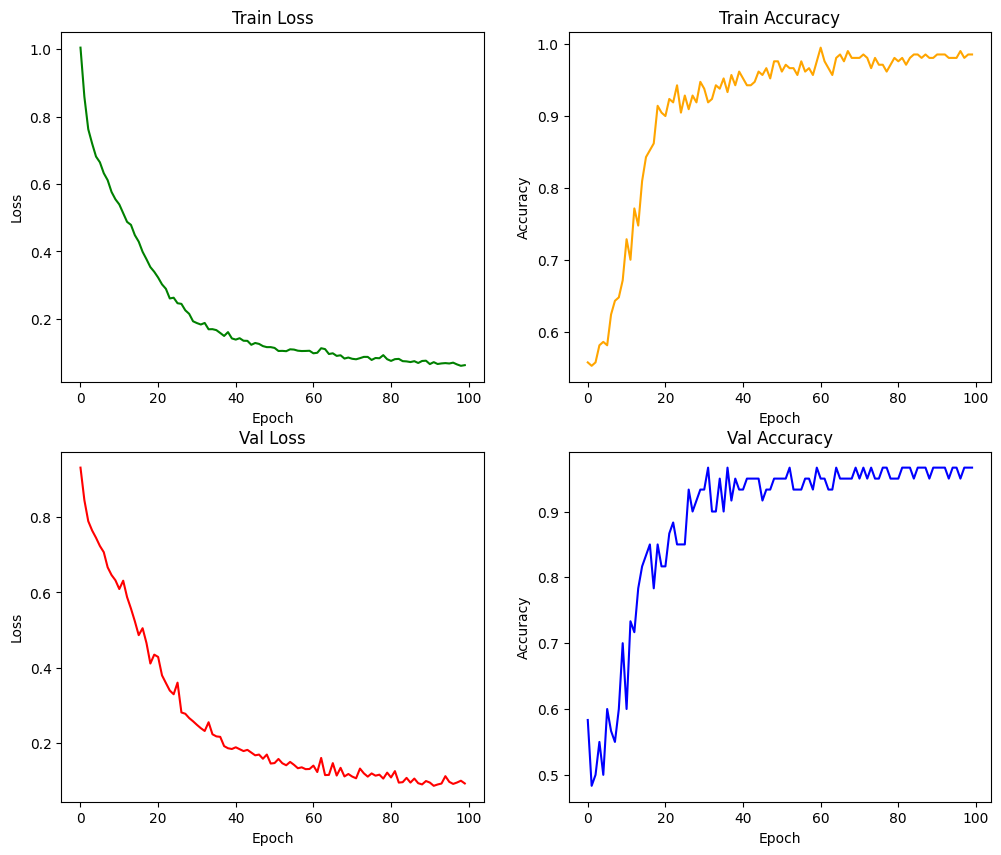

In [46]:
fig, ax = plt.subplots(2, 2, figsize =(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Train Loss')

ax[0, 1].plot(train_accs, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[0, 1].set_title('Train Accuracy')

ax[1, 0].plot(val_losses, color='red')
ax[1, 0].set(xlabel='Epoch', ylabel='Loss')
ax[1, 0].set_title('Val Loss')

ax[1, 1].plot(val_accs, color='blue')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Val Accuracy')

plt.show()

In [47]:
test_target = []
test_pred = []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_pred.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_pred = torch.cat(test_pred)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_pred, test_target)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9667
